In [1]:
import healpy as hp
import pandas as pd
import numpy as np
import math
from skimage.feature import peak_local_max
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import astropy.coordinates as coord
import matplotlib.pyplot as plt

In [2]:
%store -r table_PS_obs

In [3]:
%store -r prediction_E_64pix_9epoch_10batch

In [4]:
# lonlat values of the patches, stored from P_input_map.ipynb
%store -r lon
%store -r lat
%store -r xsize
%store -r reso

In [5]:
# peak_distance_tol: Tolerance radius for considering two peaks as the same (in pixels)
def get_peaks_lonlat(prediction_patches, lon, lat, xsize, reso, threshold_abs, peak_distance_tol=5):
    peak_coords = []

    for patch, patch_lon, patch_lat in zip(prediction_patches, lon, lat):
        patch = np.squeeze(patch)  # Remove the single-dimensional axis
        peak_indices = peak_local_max(patch, min_distance=peak_distance_tol, threshold_abs=threshold_abs, exclude_border=False)
        peak_probs = patch[peak_indices[:, 0], peak_indices[:, 1]]

        proj = hp.projector.GnomonicProj(ysize=xsize, xsize=xsize, rot=(patch_lon, patch_lat, 0), reso=reso)

        x, y = proj.ij2xy(peak_indices[:, 0], peak_indices[:, 1])
        lon_coords, lat_coords = proj.xy2ang(x=x, y=y, lonlat=True)

        if np.isscalar(lon_coords):  
            lon_coords = [lon_coords] 

        if np.isscalar(lat_coords):  
            lat_coords = [lat_coords]  

        for i in range(len(lon_coords)):
            peak_coords.append((lon_coords[i], lat_coords[i], peak_probs[i]))

    return peak_coords


In [6]:
table_PS_pred_list = []  # List to store the tables

for k in np.arange(0.1, 1, 0.1):
    table_PS_pred = pd.DataFrame(columns=['lon(°)', 'lat(°)', 'p(0,1)'])
    peaks_pred = get_peaks_lonlat(prediction_E_64pix_9epoch_10batch, lon, lat, xsize, reso, threshold_abs=k)

    for patch in peaks_pred:
        lon_patch, lat_patch, probability = patch

        patch_df = pd.DataFrame({'lon(°)': [lon_patch], 'lat(°)': [lat_patch], 'p(0,1)': [probability]})

        table_PS_pred = pd.concat([table_PS_pred, patch_df], ignore_index=True)

    table_PS_pred_list.append(table_PS_pred)  

In [7]:
table_detections_list = []
table_spurious_list = []

for table_PS_pred in table_PS_pred_list:
    pred_lons = table_PS_pred['lon(°)']
    pred_lats = table_PS_pred['lat(°)']
    pred_probs = table_PS_pred['p(0,1)']

    obs_lons = table_PS_obs['lon(°)']
    obs_lats = table_PS_obs['lat(°)']

    pred_lons_rad = np.radians(pred_lons.values)
    pred_lats_rad = np.radians(pred_lats.values)

    obs_lons_rad = np.radians(obs_lons.values)
    obs_lats_rad = np.radians(obs_lats.values)

    table_detections = pd.DataFrame(columns=['lon(°)', 'lat(°)', 'pred_lon', 'pred_lat', 'p(0,1)', 'S(Jy)'])
    table_spurious = pd.DataFrame(columns=['lon(°)', 'lat(°)', 'p(0,1)'])

    for pred_idx, (pred_lon_rad, pred_lat_rad, pred_lon, pred_lat, pred_prob) in enumerate(
            zip(pred_lons_rad, pred_lats_rad, pred_lons, pred_lats, pred_probs)):
        angular_separations = np.degrees(
            coord.angular_separation(pred_lon_rad, pred_lat_rad, obs_lons_rad, obs_lats_rad))

        closest_observation = None
        closest_distance = np.inf

        closest_obs_idx = np.argmin(angular_separations)
        closest_distance = angular_separations[closest_obs_idx]

        if closest_distance <= 0.2:  # deg #3.53 pix approx
            obs_idx = table_PS_obs.index[closest_obs_idx]
            obs_lon = table_PS_obs.loc[obs_idx, 'lon(°)']
            obs_lat = table_PS_obs.loc[obs_idx, 'lat(°)']
            obs_sjy = table_PS_obs.loc[obs_idx, 'S(Jy)']

            if obs_sjy in table_detections['S(Jy)'].values:
                # Get the indices of the existing detections with the same flux value
                matching_indices = table_detections.index[table_detections['S(Jy)'] == obs_sjy]

                # Calculate distances between the current observation and the matching predictions
                distances = np.degrees(coord.angular_separation(obs_lons_rad[obs_idx], obs_lats_rad[obs_idx],
                                                               pred_lons_rad[matching_indices],
                                                               pred_lats_rad[matching_indices]))

                # Find the index of the closest matching prediction
                closest_pred_idx = matching_indices[np.argmin(distances)]

                # Remove the existing detection that is farther away
                table_detections = table_detections.drop(index=closest_pred_idx)

            table_detections = pd.concat([
                table_detections,
                pd.DataFrame([[obs_lon, obs_lat, pred_lon, pred_lat, pred_prob, obs_sjy]],
                             columns=['lon(°)', 'lat(°)', 'pred_lon', 'pred_lat', 'p(0,1)', 'S(Jy)'])
            ], ignore_index=True)
        else:
            table_spurious = pd.concat([
                table_spurious,
                pd.DataFrame([[pred_lon, pred_lat, pred_prob]], columns=['lon(°)', 'lat(°)', 'p(0,1)'])
            ], ignore_index=True)

    table_detections_list.append(table_detections)
    table_spurious_list.append(table_spurious)


In [8]:
table_detections_E = table_detections_list[2]
table_spurious_E = table_spurious_list[2]

In [9]:
%store table_detections_E
%store table_spurious_E

Stored 'table_detections_E' (DataFrame)
Stored 'table_spurious_E' (DataFrame)


In [10]:
table_PS_obs_sorted = table_PS_obs.sort_values(by='S(Jy)', ascending=True)
table_PS_obs_sorted_flux = table_PS_obs_sorted['S(Jy)']
table_PS_obs_sorted_flux = table_PS_obs_sorted_flux.reset_index(drop=True)


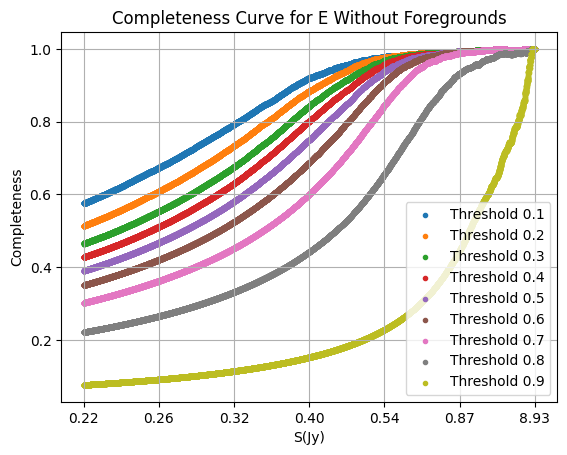

In [11]:
ratio_list_list = []

for table_detections in table_detections_list:
    ratio_list = []
    
    for i in np.arange(0, len(table_PS_obs_sorted_flux) - 1):
        num = sum(table_detections['S(Jy)'] > table_PS_obs_sorted_flux[i])
        den = sum(table_PS_obs['S(Jy)'] > table_PS_obs_sorted_flux[i])
        if den != 0:
            ratio = num / den
        else:
            ratio = 0
        ratio_list.append(ratio)

    ratio_list_list.append(ratio_list)

fig, ax = plt.subplots()
for i, ratio_list in enumerate(ratio_list_list):
    threshold = (i + 1) / 10.0  
    ax.scatter(np.arange(0, len(table_PS_obs_sorted_flux) - 1), ratio_list, marker='.', label=f'Threshold {threshold:.1f}')
    
ax.set_title('Completeness Curve for E Without Foregrounds')
ax.set_xlabel('S(Jy)')
ax.set_ylabel('Completeness')
ax.grid(True)

num_ticks = 6

step_size = max(1, len(table_PS_obs_sorted_flux) // num_ticks)

ax.locator_params(axis='x', nbins=num_ticks)
ax.set_xticks(table_PS_obs_sorted_flux.index[::step_size])
ax.set_xticklabels([f'{val:.2f}' for val in table_PS_obs_sorted_flux.values[::step_size]])

ax.legend()
plt.savefig('CompletenessnoforegE.jpg', dpi = 200)
plt.show()


In [12]:
completeness_E_03 = ratio_list_list[2]
%store completeness_E_03

Stored 'completeness_E_03' (list)


In [13]:
R_list = []

for table_spurious, table_detections in zip(table_spurious_list, table_detections_list):
    R = 1 - len(table_spurious) / (len(table_spurious) + len(table_detections))
    R_list.append(R)


In [14]:
R_list_E = R_list
%store R_list_E

Stored 'R_list_E' (list)


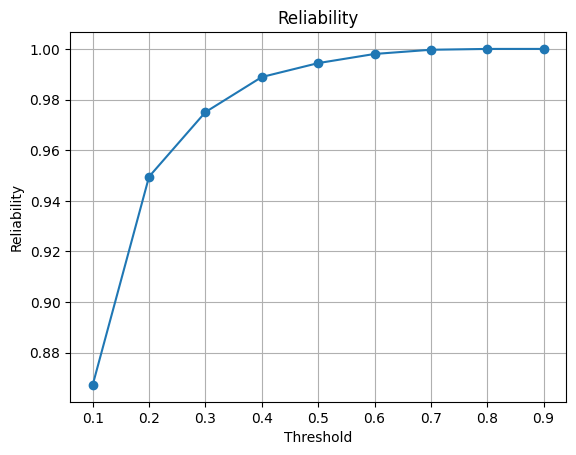

In [15]:
plt.plot(np.arange(0.1,1,0.1), R_list, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Reliability')
plt.title('Reliability')
plt.grid(True)
plt.savefig('Reliability.jpg')
plt.show()

Important note: the function get_peaks_lonlat, which converts ij to lonlat positions for the Prediction, somehow returns more positions than the truly positions of the points sources there are. That is why we can find several positions in the pred table that are very close together (1 pix apart, although the min_distance in peak_local_max is 5 pix) corresponding to one position in the obs table. That is why the total number of detections are not the number of items in the pred table, but rather the sum of the spurious and the detected items, as there has been a *filter* inside the code that among 2 predictions that correspond to 1 observation, it chooses the closest one.



Also, there can be another source of error accounting for this function. This can be seen in the ij2lonlat test where there is a distance difference of 0.05 degrees at max between the input lonlat and the output lonlat